In [1]:
%matplotlib notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as stats
import re
import camelot

# Results of the most recent European Elections in Germany (2019). 
Source: https://www.bundeswahlleiter.de/europawahlen/2019/ergebnisse.html (last accessed 2019-07-27).

Contains results for all cities and free regions for all 16 German Laender and aggregated Data for Laender. 

In [2]:
EuElect = pd.read_csv('ew19_kerg.csv',sep=';',skiprows=[0],header=[1])#,index_col=-1)
EuElect = EuElect[EuElect.isnull().Nr==False]
EuElect.set_index('Nr',inplace=True)
EuElect.head()

,Gebiet,gehört zu,Wahlberechtigte,Unnamed: 4,Wähler/-innen,Unnamed: 6,Ungültige,Unnamed: 8,Gültige,Unnamed: 10,...,Unnamed: 86,PARTEI FÜR DIE TIERE DEUTSCHLAND,Unnamed: 88,Partei für Gesundheitsforschung,Unnamed: 90,Volt Deutschland,Unnamed: 92,Übrige,Unnamed: 94,Unnamed: 95
Nr,,,,,,,,,,,,,,,,,,,,,
1001.0,"Flensburg, Stadt",1.0,70431,70929,39647,25350,237,176,39410,25174,...,NaN,61,NaN,47,NaN,285,NaN,NaN,160,NaN
1002.0,"Kiel, Landeshauptstadt",1.0,186195,188135,109595,75741,577,405,109018,75336,...,NaN,144,NaN,129,NaN,1139,NaN,NaN,283,NaN
1003.0,"Lübeck, Hansestadt",1.0,166530,167198,90946,62933,461,424,90485,62509,...,NaN,126,NaN,104,NaN,935,NaN,NaN,256,NaN
1004.0,"Neumünster, Stadt",1.0,60215,60970,29036,27659,231,409,28805,27250,...,NaN,56,NaN,34,NaN,114,NaN,NaN,185,NaN
1051.0,Dithmarschen,1.0,107045,107804,58244,42819,475,469,57769,42350,...,NaN,118,NaN,111,NaN,185,NaN,NaN,168,NaN


In [3]:
# Getting AfD 2019 and 2014
AfD_colname=list(EuElect.columns.str.contains('Alternative'))
AfD_colind = np.where(AfD_colname)[0][0]
election = EuElect.iloc[:, [a for a in np.arange(10)]+[AfD_colind, AfD_colind+1]]
# columns in German
election.columns = ['Gebiet'
              , 'gehört zu'
              , 'Wahlberechtigte 2019'
              , 'Wahlberechtigte 2014'
              , 'Wähler/-innen 2019'
              , 'Wähler/-innen 2014'
              , 'Ungültige 2019'
              , 'Ungültige 2014'
              , 'Gültige 2019'
              , 'Gültige 2014'
              , 'AfD 2019'
              , 'AfD 2014']
election.columns = ['region'
              , 'subregion'
              , 'eligible_voters_19'
              , 'eligible_voters_14'
              , 'voters_19'
              , 'voters_14'
              , 'invalid_19'
              , 'invalid_14'
              , 'valid_19'
              , 'valid_14'
              , 'afd_19'
              , 'afd_14']
# creating a common index for merge later on
election.index = [str(int(a)) for a in election.index]

election.to_csv('election_aux.csv',index=False, sep=';',decimal=',',encoding='utf-8')
election = pd.read_csv('election_aux.csv', sep=';', decimal=',')
election.head()

,region,subregion,eligible_voters_19,eligible_voters_14,voters_19,voters_14,invalid_19,invalid_14,valid_19,valid_14,afd_19,afd_14
0,"Flensburg, Stadt",1.0,70431,70929,39647,25350,237,176,39410,25174,2477,1583
1,"Kiel, Landeshauptstadt",1.0,186195,188135,109595,75741,577,405,109018,75336,6459,4418
2,"Lübeck, Hansestadt",1.0,166530,167198,90946,62933,461,424,90485,62509,6773,4334
3,"Neumünster, Stadt",1.0,60215,60970,29036,27659,231,409,28805,27250,2761,1960
4,Dithmarschen,1.0,107045,107804,58244,42819,475,469,57769,42350,5121,2325


### Data on Overindebtedness in Germany from Creditreform 
https://www.creditreform.de/aktuelles-wissen/pressemeldungen-fachbeitraege/show/schuldneratlas-deutschland-2018, last retrieved 2019-07-31.

In [4]:
def umlaut(string):
    string = re.sub('Ã¼', 'ü',string)
    string = re.sub('ÃŸ', 'ß', string)
    string = re.sub('Ã¶', 'ö', string)
    string = re.sub('Ã¤', 'ä', string)
    return string
#string = 'WÃŸÃ¶ Ã¤'
#umlaut(string)


In [5]:
creditreform = pd.read_csv('SchuldnerAtlas2018.csv', sep=';' ,skiprows=8, decimal=',')
creditreform.columns = ['nr', 'region', 'state', 'state_abbrev', '2013', '2014', '2015', '2016', '2017', '2018']
# drop meta info at the bottom
creditreform = creditreform.iloc[0:472,:]
# drop rows that are headers on each of the 10 pages of the original file
creditreform = creditreform[creditreform.state != 'Bundesland']
# drop blank lines
creditreform = creditreform[creditreform.isnull().region==False]
# correct for wrong reading of German "Umlaute"
creditreform['region'] = creditreform['region'].apply(umlaut, 'region')
#creditreform[['2013','2014','2015']]=creditreform[['2013','2014','2015']].apply(lambda x: re.sub(',','.',x))

# part of the columns have not been read in as floats, by writing and reading back in this is corrected for.
creditreform.to_csv('creditreform_check.csv', index=False, decimal=',', encoding='utf-8')
creditreform = pd.read_csv('creditreform_check.csv', decimal=',')
creditreform.head()

,nr,region,state,state_abbrev,2013,2014,2015,2016,2017,2018
0,1.,"Aachen, Städteregion",Nordrhein-Westfalen,SV,11.02,11.06,10.94,11.21,11.11,11.18
1,2.,Ahrweiler,Rheinland-Pfalz,LK,8.72,8.60,8.32,8.61,8.65,8.67
2,3.,Aichach-Friedberg,Bayern,LK,5.27,5.19,5.17,5.58,5.62,5.61
3,4.,Alb-Donau-Kreis,Baden-WÃ¼rttemberg,LK,5.72,5.80,5.90,6.22,6.38,6.49
4,5.,Altenburger Land,ThÃ¼ringen,LK,8.29,8.66,8.72,8.84,8.87,8.95


# Joining election and overindebtedness data

In [6]:
creditreform.set_index('region',inplace=True)
creditreform.rename(index={
    'Aachen, Städteregion': 'Städteregion Aachen',
    'Baden-Baden, Stadtkreis': 'Baden-Baden, Stadt',
    'Düren, Kreis': 'Düren',
    'Freiburg im Breisgau, Stadtkreis': 'Freiburg im Breisgau, Stadt',
    'Heidelberg, Stadtkreis': 'Heidelberg, Stadt',
    'Heilbronn, Stadtkreis': 'Heilbronn, Stadt',
    'Karlsruhe, Stadtkreis': 'Karlsruhe, Stadt',
    'Kleve, Kreis': 'Kleve',
    'Ludwigshafen am Rhein, kreisfr. Stadt': 'Ludwigshafen am Rhein, kreisfreie Stadt',
    'Mannheim, Stadtkreis': 'Mannheim, Universitätsstadt',
    'Mettmann, Kreis': 'Mettmann',
    'Neustadt a.d. Weinstraße, Stadt': 'Neustadt an der Weinstraße, kreisfreie Stadt',
    'Pforzheim, Stadtkreis': 'Pforzheim, Stadt', 
    'Schwabach': 'Schwabach, Stadt',
    'Stuttgart, Stadtkreis': 'Stuttgart, Landeshauptstadt', 
    'Ulm, Stadtkreis': 'Ulm, Universitätsstadt',
    'Viersen, Kreis': 'Viersen',
    'Wesel, Kreis': 'Wesel',
    'Deutschland': 'Bundesgebiet'
},inplace=True)
creditreform.reset_index(inplace=True)    
df = election.merge(creditreform, how='outer', left_on='region', right_on='region')#, indicator=True
df_state = df[df['subregion']==99]
df = df[df['subregion']!=99]
# the following tables where used to find mismatches
    #el_no_match = df[df['_merge']=='left_only']
    #print(el_no_match[el_no_match.subregion!=99.0])
    #df[df._merge=='right_only']
df.head()

,region,subregion,eligible_voters_19,eligible_voters_14,voters_19,voters_14,invalid_19,invalid_14,valid_19,valid_14,...,afd_14,nr,state,state_abbrev,2013,2014,2015,2016,2017,2018
0,"Flensburg, Stadt",1.0,70431,70929,39647,25350,237,176,39410,25174,...,1583,100.,Schleswig-Holstein,KS,16.41,16.40,16.21,16.17,16.21,16.24
1,"Kiel, Landeshauptstadt",1.0,186195,188135,109595,75741,577,405,109018,75336,...,4418,172.,Schleswig-Holstein,KS,12.04,12.03,12.17,12.23,12.16,11.96
2,"Lübeck, Hansestadt",1.0,166530,167198,90946,62933,461,424,90485,62509,...,4334,198.,Schleswig-Holstein,KS,15.25,15.59,15.26,15.29,15.04,14.76
3,"Neumünster, Stadt",1.0,60215,60970,29036,27659,231,409,28805,27250,...,1960,235.,Schleswig-Holstein,KS,16.61,16.94,17.09,17.54,17.80,18.09
4,Dithmarschen,1.0,107045,107804,58244,42819,475,469,57769,42350,...,2325,73.,Schleswig-Holstein,K,12.52,12.80,12.43,12.78,12.78,12.84


# Adding some columns
- relative share of votes for AfD per voters 19 and 14(afd_vot19 and afd_vot14)
- relative share of votes for AfD per eligable_voters (afd_eli19)
- relative share of votes for Afd per valid votes cast (afd_val19)
- change in share of overindebted adults from 2013 to 2018 in % (ove18_13)
- change in share of AfD between 19 and 14 (vot19_14)

In [7]:
df.columns

Index(['region', 'subregion', 'eligible_voters_19', 'eligible_voters_14',
       'voters_19', 'voters_14', 'invalid_19', 'invalid_14', 'valid_19',
       'valid_14', 'afd_19', 'afd_14', 'nr', 'state', 'state_abbrev', '2013',
       '2014', '2015', '2016', '2017', '2018'],
      dtype='object')

In [8]:
df['afd_vot19']= df.afd_19 / df.voters_19*100
df['afd_eli19']= df.afd_19 / df.eligible_voters_19*100
# Thats the statistic reported on, as it reflects outcome
df['afd_val19']= df.afd_19 / df.valid_19*100
df['afd_val14']= df.afd_14 / df.valid_14*100
df['ove18_13']=df['2018']-df['2013']
df['vot19_14']=df.afd_val19-df.afd_val14
df['part']='blue'
df.loc[df['subregion']>=12,'part']='red'
df.tail()

,region,subregion,eligible_voters_19,eligible_voters_14,voters_19,voters_14,invalid_19,invalid_14,valid_19,valid_14,...,2016,2017,2018,afd_vot19,afd_eli19,afd_val19,afd_val14,ove18_13,vot19_14,part
412,Saale-Holzland-Kreis,16.0,68278,70654,45101,41321,1003,1171,44098,40150,...,7.46,7.43,7.50,22.638079,14.953572,23.152977,9.763387,0.10,13.389590,red
413,Saale-Orla-Kreis,16.0,67029,71195,42514,38529,884,1181,41630,37348,...,7.56,7.52,7.47,26.494802,16.804667,27.057411,8.337796,-0.01,18.719615,red
414,Greiz,16.0,82940,88102,53197,48740,1139,1551,52058,47189,...,7.96,7.80,7.76,24.995770,16.032071,25.542664,9.661150,0.34,15.881514,red
415,Altenburger Land,16.0,75936,80935,42954,39093,1053,1436,41901,37657,...,8.84,8.87,8.95,26.472505,14.974452,27.137777,8.027724,0.66,19.110053,red
417,Bundesgebiet,NaN,61600263,61998824,37807746,29843798,410857,488706,37396889,29355092,...,10.06,10.04,10.04,10.856117,6.663045,10.975386,7.051635,0.23,3.923751,blue


<IPython.core.display.Javascript object>


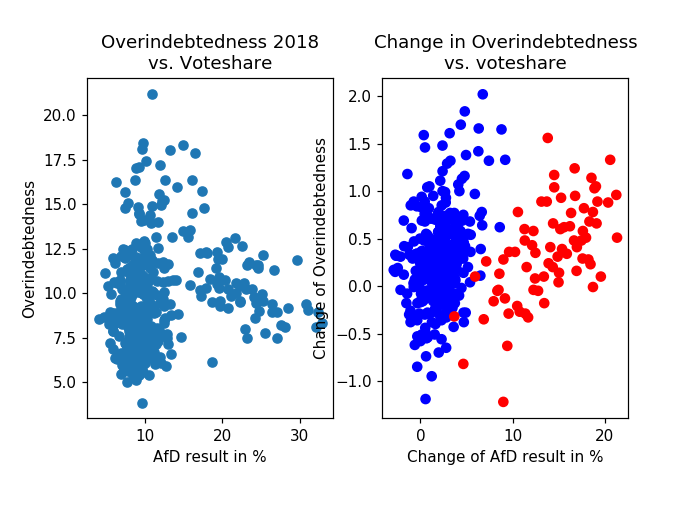

Text(0.5, 0, 'Change of AfD result in %')

In [10]:
f, (ax1, ax2) = plt.subplots(1, 2)#, sharey=True)
f.figsize=(9,6)
ax1.set_title('Overindebtedness 2018\nvs. Voteshare')
plt.subplots_adjust(top=0.85,bottom=0.2)
ax1.scatter( df.afd_val19,df['2018'])
ax1.set_ylabel('Overindebtedness')
ax1.set_xlabel('AfD result in %')

ax2.set_title('Change in Overindebtedness\nvs. voteshare')

ax2.scatter(df.vot19_14, df.ove18_13, c=df.part )
ax2.set_ylabel('Change of Overindebtedness')
ax2.set_xlabel('Change of AfD result in %')

## Structural data as provided by the Federal Statistical Office of Germany (Statistisches Bundesamt)

Here, we make use of the data provided by the Federal Returning Officer (Bundeswahlleiter) for the 2014 European elections https://www.bundeswahlleiter.de/en/europawahlen/2014/strukturdaten.html and the 2019 European elections https://www.bundeswahlleiter.de/en/europawahlen/2019/strukturdaten.html.

In [321]:
import os    
from chardet import detect

# the file wouldn't read with the standard settings, therefore 
# get file encoding type and apply to read_csv
def get_encoding_type(file):
    with open(file, 'rb') as f:
        rawdata = f.read()
    return detect(rawdata)['encoding']

file='ew19_strukturdaten.csv'
encoding = get_encoding_type(file)

struk19 = pd.read_csv(file,skiprows=range(8)
                      , encoding=encoding
                      , delimiter=';'
                      , decimal=',')
col_sel = np.invert(['Fußnoten' in a for a in struk19.columns])
struk19 = struk19.iloc[:,col_sel]

# some of the variables have been read as obj as read_csv does 
# not handle % AND comma decimal correctly

# getting the columnnames as list
obj_bool = struk19.dtypes == 'object'
obj_coln = list(struk19.columns.values[obj_bool])
obj_l_ind = [a for a in range(len(struk19.columns)) if struk19.columns.values[a] in obj_coln]

# the first 2 columns are text data that do not need to be converted
# therefore [2:]
obj_coln = obj_coln[2:]


def cleaner(x):
    try:
        result = float(re.sub(',','.',x))
    except:
        result = np.nan
    return result


for i in obj_l_ind[2:]:
    struk19.iloc[:,i] = struk19.iloc[:,i].apply(cleaner)
struk19.iloc[:,obj_l_ind[2:]].describe()

,Zu- (+) bzw. Abnahme (-) der Bevölkerung 2017 - Geburtensaldo (je 1000 Einwohner),Zu- (+) bzw. Abnahme (-) der Bevölkerung 2017 - Wanderungssaldo (je 1000 Einwohner),Schutzsuchende gemäß Ausländerzentralregister am 31.12.2017 - insgesamt (je 1000 Einwohner),Schutzsuchende gemäß Ausländerzentralregister am 31.12.2017 - mit offenem Schutzstatus (%),Schutzsuchende gemäß Ausländerzentralregister am 31.12.2017 - mit anerkanntem Schutzstatus (%),Schutzsuchende gemäß Ausländerzentralregister am 31.12.2017 - mit abgelehntem Schutzstatus (%),Absolventen/Abgänger beruflicher Schulen 2017 (je 1000 Einwohner),Absolventen/Abgänger allgemeinbildender Schulen 2017 - mit allgemeiner und Fachhochschulreife (%),"Sozialversicherungspflichtig Beschäftigte am 30.06.2018 - Land- und Forstwirtschaft, Fischerei (%)",Sozialversicherungspflichtig Beschäftigte am 30.06.2018 - Produzierendes Gewerbe (%),"Sozialversicherungspflichtig Beschäftigte am 30.06.2018 - Handel, Gastgewerbe, Verkehr (%)",Sozialversicherungspflichtig Beschäftigte am 30.06.2018 - Öffentliche und private Dienstleister (%)
count,435.000000,441.000000,436.000000,436.000000,436.000000,436.000000,438.000000,440.000000,426.000000,434.000000,440.000000,436.000000
mean,-2.745977,5.102721,18.976835,22.200459,66.892661,10.906422,3.487443,32.984318,1.149765,32.042857,22.368864,16.467890
std,2.690982,4.149714,9.244607,9.446826,12.804462,5.544918,2.429341,8.413927,1.228280,10.384764,4.453926,6.922841
min,-9.700000,-14.000000,2.100000,2.700000,20.000000,1.500000,0.100000,11.100000,0.000000,7.600000,10.200000,6.400000
25%,-4.400000,2.700000,12.600000,15.775000,60.000000,7.200000,1.900000,27.100000,0.300000,24.425000,19.375000,11.400000
50%,-2.600000,5.000000,18.050000,21.350000,68.100000,9.850000,2.950000,32.400000,0.800000,31.550000,21.900000,14.550000
75%,-1.000000,7.300000,23.400000,27.200000,74.575000,13.300000,4.375000,38.400000,1.700000,40.175000,24.725000,19.525000
max,4.300000,21.300000,124.300000,57.800000,94.800000,33.500000,14.900000,57.900000,9.300000,62.900000,48.300000,44.200000


In [322]:
file='ew14_strukturdaten.csv'
struk14 = pd.read_csv(file,skiprows=[0,1,2,3,5]
                      , encoding='Windows-1252'
                      , error_bad_lines=False
                      ,delimiter=';'
                      ,decimal=',')
col_sel = np.invert(['Bemerkungen' in a for a in struk14.columns])
struk14 = struk14.iloc[:,col_sel]
obj_bool = struk14.dtypes == 'object'
obj_coln = list(struk14.columns.values[obj_bool])
obj_l_ind = [a for a in range(len(struk14.columns)) if struk14.columns.values[a] in obj_coln]
#struk14.columns.values[obj_l_ind]
struk14[obj_coln].head()

obj_coln = obj_coln[2:]

for i in obj_l_ind[2:]:
    struk14.iloc[:,i] = struk14.iloc[:,i].apply(cleaner)
struk14.describe()


#struk14.iloc[:,obj_coln]
struk14[obj_coln].describe()

,Zu- (+) bzw. Abnahme (-) der Bevölkerung 2012 - Wanderungssaldo (je 1000 Einwohner),Allgemein bildendes Schulwesen: Absolventen/Abgänger nach dem Abschluss 2012 - mit allgemeiner Hochschulreife (%),Insolvenzverfahren 2012 - Beschäftigte (je 1000 Einwohner)
count,442.000000,441.000000,438.000000
mean,3.407466,34.091156,2.135845
std,4.754019,9.795437,7.414718
min,-11.000000,11.800000,0.100000
25%,0.100000,26.600000,0.725000
50%,3.450000,33.700000,1.300000
75%,6.300000,40.500000,2.200000
max,20.000000,65.700000,147.700000


In [323]:
# exporting columns for (manual) translation and comparison with corresponding dataset 2014
pd.DataFrame(struk14.columns).to_excel('struk14_cols.xlsx')
pd.DataFrame(struk19.columns).to_excel('struk19_cols.xlsx')

In [324]:
# This cell reads the manually checked headings for 2019 and 2014 back in. It contains translations (transl)
# of the headings and variable names and a Comment line indicating if 2019 and 2014 values are comparable or 
# not
struk_ov = pd.read_excel('struk19_vs_struk14.xlsx')
struk_ov.head()

,desc_2019,desc_2014,transl_2019,transl_2014,variable_2019,variable_2014,Comment
0,Land,Land,region,region,region_2019,region_2014,comparable
1,Kreis,Kreis,county,county,county_2019,county_2014,comparable
2,Name,Name,name,name,name_2019,name_2014,comparable
3,Gemeinden am 31.12.2017 (Anzahl),Gemeinden am 31.12.2013 (Anzahl),Municipalities on 31.12.2017 (number),Municipalities on 31.12.2013 (number),municipalities_2017,municipalities_2013,comparable
4,Fläche am 31.12.2017 (km²),Fläche am 31.12.2012 (km²),Area on 31.12.2017 (km²),Area on 31.12.2012 (km²),area_2017,area_2012,comparable


In [325]:
# Renaming the variables for ease of typing
rn_19 = dict()
for i in range(len(struk_ov)):
    old_name = struk_ov.desc_2019.iloc[i]
    new_name = struk_ov.variable_2019.iloc[i]
    #print(old_name)
    if isinstance(old_name,str) and (old_name in struk19.columns):
        rn_19.update({old_name: new_name})
type(struk19)
[a in struk19.columns for a in struk_ov.desc_2019]
struk19 = struk19.rename(columns=rn_19)

rn_14 = dict()
for i in range(len(struk_ov)):
    old_name = struk_ov.desc_2014.iloc[i]
    new_name = struk_ov.variable_2014.iloc[i]
    #print(old_name)
    if isinstance(old_name,str) and (old_name in struk14.columns):
        rn_14.update({old_name: new_name})

struk14 = struk14.rename(columns=rn_14)

In [326]:
struk19.head()

,region_2019,county_2019,name_2019,municipalities_2017,area_2017,population_2017,germans_2017,foreigners_2017,population_density_2017,birth_balance_2017,...,empl_service_2018,empl_oth_service_2018,hartz_total_2018,hartz_no_empl_2018,hartz_foreign_2018,unempl_total_2019,unempl_male_2019,unempl_female_2019,unempl_15_19_2019,unempl_55_64_2019
0,Schleswig-Holstein,1001,"Flensburg, Stadt",1,56.7,88.5,76.8,13.3,1560.4,-1.7,...,20.1,38.7,137.9,25.6,29.7,8.2,9.0,7.2,5.1,7.7
1,Schleswig-Holstein,1002,"Kiel, Landeshauptstadt",1,118.7,247.9,220.0,11.3,2089.7,0.1,...,26.2,38.7,140.4,26.8,33.6,7.9,8.9,6.9,4.7,8.2
2,Schleswig-Holstein,1003,"Lübeck, Hansestadt",1,214.2,216.3,195.4,9.7,1009.9,-3.6,...,22.9,28.9,122.5,26.6,27.0,7.8,8.5,7.0,5.0,7.6
3,Schleswig-Holstein,1004,"Neumünster, Stadt",1,71.7,79.3,70.6,11.0,1107.1,-5.4,...,20.0,26.2,123.1,26.5,25.7,8.3,8.5,7.9,6.3,7.5
4,Schleswig-Holstein,1051,Dithmarschen,116,1428.2,133.4,126.0,5.6,93.4,-5.3,...,11.4,32.0,87.8,27.4,23.0,6.4,6.7,6.0,4.9,6.3


In [327]:
# creating new columns containing changes
comparable = struk_ov.iloc[6:,]
comparable = comparable[comparable['Comment']=='comparable']
comparable.head()
chg = ['population_2012', 'germans_2012']
for i in range(len(comparable)):
    #print(i)
    var19 = comparable.variable_2019.iloc[i]
    var14 = comparable.variable_2014.iloc[i]
    var_ch = var19+'_'+var14[-4:]
    struk19[var_ch] = struk19[var19] - struk14[var14]
struk19[var19].dtype
struk14[var14].dtype 
struk19.dtypes

region_2019                                                                                           object
county_2019                                                                                            int64
name_2019                                                                                             object
municipalities_2017                                                                                    int64
area_2017                                                                                            float64
population_2017                                                                                      float64
germans_2017                                                                                         float64
foreigners_2017                                                                                      float64
population_density_2017                                                                              float64
birth_balance_2017 

In [339]:
df = df.merge(struk19, left_on='region',right_on='name_2019', how='left')

In [341]:
df.head()
df.shape

(402, 109)

## Regional Data on unemployment and population statistics
Source: https://www.regionalstatistik.de, last accessed: 2019-07-27.
Unemployment Data ("13211-02-05-4.xlsx") is for 2018, most recent data. 


In [10]:

unemployment = pd.read_excel('13211-02-05-4.xlsx',index_col=0,header=[2,3,4])

# eliminating empty rows
unemployment = unemployment[unemployment.iloc[:,2].isnull()==False]

#unemployment.columns
#[re.sub('^0','',index) for index in unemployment.index]
index_new=[]
for i in range(len(unemployment)): 
    index_new.append(re.sub('^0','',unemployment.index[i])) 
unemployment.index = index_new




unemployment.columns= [
                 'Gebiet'
                , 'Arbeitslose'
                , 'Arbeitslose Ausländer'
                , 'Arbeitslose Schwerbehinderte'
                , 'Arbeitslose 15-20 Jährige'
                , 'Arbeitslose 15-25 Jährige'
                , 'Arbeitslose 55-65 Jährige'
                , 'Langzeitarbeitslose'
                , 'AL-Quote abh. zivile Erwerbspersonen'
                , 'AL-Quote alle zivilen Erwerbspersonen'
                , 'AL-Quote alle zivilen Erwerbspersonen, Männer'
                , 'AL-Quote alle zivilen Erwerbspersonen, Frauen'
                , 'AL-Quote alle zivilen Erwerbspersonen, Ausländer'
                , 'AL-Quote alle zivilen Erwerbspersonen, 15-25'
                    ]
unemployment.head(50)
unemployment.rename(index={'DG':'99'}, inplace=True)

#unemployment.columns
unemployment.head() 
df.index = [re.sub('.0','',str(i)) for i in df.subregion]
df.head()
unemployment.head(30)

,Gebiet,Arbeitslose,Arbeitslose Ausländer,Arbeitslose Schwerbehinderte,Arbeitslose 15-20 Jährige,Arbeitslose 15-25 Jährige,Arbeitslose 55-65 Jährige,Langzeitarbeitslose,AL-Quote abh. zivile Erwerbspersonen,AL-Quote alle zivilen Erwerbspersonen,"AL-Quote alle zivilen Erwerbspersonen, Männer","AL-Quote alle zivilen Erwerbspersonen, Frauen","AL-Quote alle zivilen Erwerbspersonen, Ausländer","AL-Quote alle zivilen Erwerbspersonen, 15-25"
99,Deutschland,2340082,625583,156621,44259,210342,506267,813409,5.8,5.2,5.4,5,12.9,4.6
1,Schleswig-Holstein,85053,17965,4885,1756,8503,17810,29345,6.1,5.5,5.8,5.1,17.9,5.1
1001,"Flensburg, Kreisfreie Stadt",4304,1006,248,93,518,642,1433,9.1,8.3,9.2,7.3,.,7
1002,"Kiel, Landeshauptstadt, Kreisfreie Stadt",11331,3018,505,168,956,1778,4355,9,8.2,9.1,7.2,.,5.6
1003,"Lübeck, Hansestadt, Kreisfreie Stadt",8907,2008,436,165,770,1605,3181,8.6,7.8,8.4,7,.,6.3
1004,"Neumünster, Kreisfreie Stadt",3532,695,192,106,414,597,1323,9.3,8.3,8.6,8,.,8.8
1051,"Dithmarschen, Landkreis",4312,669,249,129,570,843,1346,7,6.3,6.5,6,.,6.8
1053,"Herzogtum Lauenburg, Landkreis",5148,1162,329,128,533,1173,1802,5.6,5,5.2,4.7,.,5.4
1054,"Nordfriesland, Landkreis",4962,873,229,115,548,1186,1931,5.8,5.3,5.7,4.9,.,4.7
1055,"Ostholstein, Landkreis",5356,816,361,119,574,1454,1748,5.8,5.1,5.5,4.7,.,5.2


In [11]:
df_neu = df.merge(unemployment, left_index=True, right_index=True, how='left')#, indicator=True)# indicator=True)#, how='outer') 

#df.rename(columns={'Gebiet_x':'Gebiet'},inplace=True)
#df.drop(labels=['2000','11000'],inplace=True)
df.index.contains('Bremen')
df.head()

,region,subregion,eligible_voters_19,eligible_voters_14,voters_19,voters_14,invalid_19,invalid_14,valid_19,valid_14,...,2016,2017,2018,afd_vot19,afd_eli19,afd_val19,afd_val14,ove18_13,vot19_14,part
1,"Flensburg, Stadt",1.0,70431,70929,39647,25350,237,176,39410,25174,...,16.17,16.21,16.24,6.247635,3.516917,6.285207,6.288234,-0.17,-0.003027,blue
1,"Kiel, Landeshauptstadt",1.0,186195,188135,109595,75741,577,405,109018,75336,...,12.23,12.16,11.96,5.893517,3.468944,5.924710,5.864394,-0.08,0.060316,blue
1,"Lübeck, Hansestadt",1.0,166530,167198,90946,62933,461,424,90485,62509,...,15.29,15.04,14.76,7.447276,4.067135,7.485219,6.933402,-0.49,0.551817,blue
1,"Neumünster, Stadt",1.0,60215,60970,29036,27659,231,409,28805,27250,...,17.54,17.80,18.09,9.508886,4.585236,9.585141,7.192661,1.48,2.392481,blue
1,Dithmarschen,1.0,107045,107804,58244,42819,475,469,57769,42350,...,12.78,12.78,12.84,8.792322,4.783969,8.864616,5.489965,0.32,3.374651,blue


### Employment on a regional level

In [12]:
employment = pd.read_excel('13312-01-05-4.xlsx'
                           , header=[3]
                           
                           , skip=[0,1]
                          )
employment.reset_index(inplace=True)
employment.rename(columns={'level_0':'region', 'Insgesamt':'employment 2017'}, inplace=True)


employment = employment.iloc[2:540,:]
employment = employment[['region', 'employment 2017']]
employment.region[employment.region=='DG']="99"
employment.set_index('region', inplace=True)
index_new=[]
for i in range(len(employment)): 
    index_new.append(re.sub('^0','',employment.index[i]))
employment.index = index_new
employment.head(20)
#employment.shape
df_new = df.merge(employment, left_index=True, right_index=True, how='outer', indicator=True)
df_new[df_new._merge=='left_only']
#df.loc['11']

,region,subregion,eligible_voters_19,eligible_voters_14,voters_19,voters_14,invalid_19,invalid_14,valid_19,valid_14,...,2018,afd_vot19,afd_eli19,afd_val19,afd_val14,ove18_13,vot19_14,part,employment 2017,_merge
,Regionalverband Saarbrücken,10.0,243243.0,251551.0,149551.0,121445.0,2471.0,2797.0,147080.0,118648.0,...,14.52,9.093219,5.590706,9.245989,7.030881,0.39,2.215107,blue,NaN,left_only
,Merzig-Wadern,10.0,79282.0,81279.0,55222.0,49068.0,1303.0,1708.0,53919.0,47360.0,...,9.15,8.677701,6.044247,8.887405,6.097973,-0.65,2.789432,blue,NaN,left_only
,Neunkirchen,10.0,105049.0,109755.0,68364.0,56433.0,1516.0,1826.0,66848.0,54607.0,...,12.12,10.407524,6.773030,10.643550,7.222517,0.16,3.421032,blue,NaN,left_only
,Saarlouis,10.0,153711.0,158330.0,103631.0,85962.0,2441.0,3022.0,101190.0,82940.0,...,9.93,9.480754,6.391865,9.709457,6.669882,0.12,3.039576,blue,NaN,left_only
,Saarpfalz-Kreis,10.0,113837.0,117837.0,78970.0,67638.0,1649.0,2306.0,77321.0,65332.0,...,9.11,10.834494,7.516010,11.065558,7.345558,0.03,3.720000,blue,NaN,left_only
,St. Wendel,10.0,72330.0,74441.0,53802.0,48723.0,1396.0,2036.0,52406.0,46687.0,...,7.86,7.750641,5.765243,7.957104,5.875297,-0.01,2.081807,blue,NaN,left_only
nan,Bundesgebiet,NaN,61600263.0,61998824.0,37807746.0,29843798.0,410857.0,488706.0,37396889.0,29355092.0,...,10.04,10.856117,6.663045,10.975386,7.051635,0.23,3.923751,blue,NaN,left_only


## Kriminalstatistik 

https://www.bka.de

In [156]:
bka18 = pd.read_excel('BKA-LKS-F-03-T01-Kreise_excel.xlsx', skip=[0,1,2,3,4,5,6,7,8],header=8)

bka_columns = ['crime_key',
                 'crime',
                 'region_key',
                 'region_name',
                 'type_of_region',
                 'Ncases',
                 'Ncases_per_100k',
                 'Nattempts',
                 'Perc_attempts_of_cases',
                 'Ngun_threat',
                 'Nshot',
                 'Nclearup',
                 'Perc_clearup',
                 'Nsuspects',
                 'Nmale_suspects',
                 'Nfemale_suspects',
                 'Nforeign_suspects',
                 'Perc_foreign_suspects'
                ]
bka18.columns = bka_columns

bka18.set_index('region_key',inplace=True)
crime = bka18['crime'].unique()
crime = bka18.groupby(['crime_key','crime']).size()
bka18.head()

,crime_key,crime,region_name,type_of_region,Ncases,Ncases_per_100k,Nattempts,Perc_attempts_of_cases,Ngun_threat,Nshot,Nclearup,Perc_clearup,Nsuspects,Nmale_suspects,Nfemale_suspects,Nforeign_suspects,Perc_foreign_suspects
region_key,,,,,,,,,,,,,,,,,
1001,------,Straftaten insgesamt,Flensburg,KfS,8156,9213.841096,633,7.8,11,5,4878,59.8,3474,2635,839,1178,33.9
1002,------,Straftaten insgesamt,Kiel,KfS,24621,9930.104903,1787,7.3,13,8,11941,48.5,7877,6065,1812,2251,28.6
1003,------,Straftaten insgesamt,Lübeck,KfS,22685,10486.875803,1682,7.4,21,21,12727,56.1,7858,5940,1918,2068,26.3
1004,------,Straftaten insgesamt,Neumünster,KfS,10688,13471.985883,897,8.4,12,4,6660,62.3,5061,3738,1323,2465,48.7
1051,------,Straftaten insgesamt,Dithmarschen,K,7224,5413.385089,440,6.1,4,13,4163,57.6,3169,2392,777,577,18.2


In [86]:
#crime.head()
#crime.to_excel('crime_key_and_crime.xlsx')

In [193]:
# translating german description of crime types and loading back translation based on www.deepl.com translation.
#Crime_df = pd.DataFrame(crime)
#Crime_df.to_excel('crime.xlsx',index=False, header=False, encoding='utf-8')
Crime_df = pd.read_excel('crime.xlsx', index=False)#, header=None)
Crime_df

,crime_key,crime,0,description,english_label
0,515001,Beförderungserschleichung,401,carrier approximation,approximation
1,630000,"Begünstigung, Strafvereitelung (ohne Strafvere...",401,"Advantage, prevention of punishment (without p...",advantage
2,510000,"Betrug §§ 263, 263a, 264, 264a, 265, 265a-e StGB",401,"Fraud §§ 263, 263a, 264, 264a, 265, 265a-e StG...",fraud
3,640000,Brandstiftung und Herbeiführen einer Brandgefa...,401,"Arson and a fire hazard §§ 306-306d, 306f StGB...",arson
4,897000,Computerkriminalität,401,computer crime,computer
5,980100,Cybercrime im engeren Sinne,401,Cybercrime in the narrower sense,cybercrime_narrow_def
6,*50*00,Diebstahl insgesamt an/aus Kraftfahrzeugen,401,Total theft on/from motor vehicles,theft_motor_incl_out_of
7,****00,Diebstahl insgesamt und zwar:,401,"Total theft, and that is:",theft_total
8,***300,Diebstahl insgesamt von Fahrrädern einschl. un...,401,Total theft of bicycles including unauthorised...,theft_bicycle
9,***100,Diebstahl insgesamt von Kraftwagen einschl. un...,401,total theft of motor vehicles including unauth...,theft_cars
